# Population Segmentation

We are deploying two unsupervised algorithms to perform population segmentation on US census data. 

Using **principal component analysis** (PCA) to reduce the dimensionality of the original census data. Then apply **k-means** 
clustering to assign each US county to a particular cluster based on where a county lies in component space. This allows us to observe counties that are similiar to each other in socialeconomic terms.

In [1]:
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

import boto3
import sagemaker

## Step 1 Load Data from S3

In [2]:
data_bucket = 'aws-ml-blog-sagemaker-census-segmentation'

s3_client = boto3.client('s3')
obj_list=s3_client.list_objects(Bucket=data_bucket)

keys=[]
for contents in obj_list['Contents']:
    keys.append(contents['Key'])

# We should only get one key, which is the CSV file we want.
if len(keys) != 1:
    raise RuntimeError('received unexpected number of keys from {}'.format(data_bucket))
    
data_object = s3_client.get_object(Bucket=data_bucket, Key=keys[0])
data_body = data_object["Body"].read() # in Bytes
data_stream = io.BytesIO(data_body)

census_df = pd.read_csv(data_stream, header=0, delimiter=",")
display(census_df.head())

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## Step 2 Explore & Clean Data

In [3]:
# Drop rows with missing data
census_df = census_df.dropna(axis=0, how='any')
# Re-index
census_df.index = census_df['State'] + '-' + census_df['County']
# Drop useless columns
census_df = census_df.drop(columns=['CensusId', 'State', 'County'])
display(census_df.head())

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [4]:
feature_list = census_df.columns.values
print(feature_list)

['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


### 2.1 Visualize the Data

Use Histogram to plot the distribution of data by features.

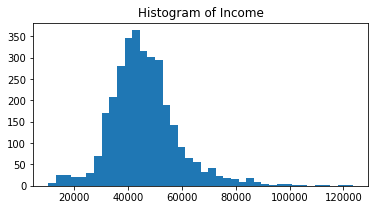

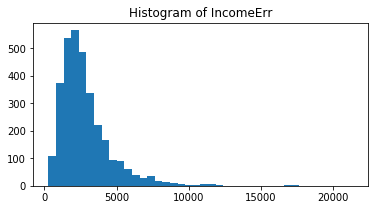

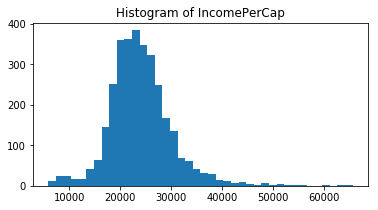

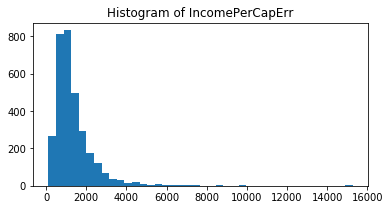

In [5]:
histogram_features = ['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr']
for column_name in histogram_features:
    ax=plt.subplots(figsize=(6,3))
    ax = plt.hist(census_df[column_name], bins=40)
    plt.title('Histogram of {}'.format(column_name), fontsize=12)
    plt.show()

### 2.2 Normalize the Data

To get a fair comparison between values, we need to normalize the data to [0, 1].

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
norm_census_df = pd.DataFrame(scaler.fit_transform(census_df.astype(float)))
norm_census_df.columns = census_df.columns
norm_census_df.index = census_df.index
display(norm_census_df.head())

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


## Step 3 Train PCA with SageMaker

Now we can apply PCA to perform dimensionality reduction. We will use SageMaker's builtin PCA algorithm.

### 3.1 Prepare the Model

In [7]:
from sagemaker import get_execution_role

session = sagemaker.Session(default_bucket='machine-learning-case-studies')
role = get_execution_role()
session_bucket = session.default_bucket()

print('Execution role: {} \nSession Bucket: {}'.format(role, session_bucket))

Execution role: arn:aws:iam::171758673694:role/service-role/AmazonSageMaker-ExecutionRole-20200315T122350 
Session Bucket: machine-learning-case-studies


In [8]:
prefix = 'population-segmentation'
model_output_path='s3://{}/{}/'.format(session_bucket, prefix)
print('Training artifcats will be uploaded to {}'.format(model_output_path))

Training artifcats will be uploaded to s3://machine-learning-case-studies/population-segmentation/


### 3.2 Train the Model

In [9]:
%%time
from sagemaker import PCA

NUM_COMPONENTS = len(feature_list) - 1

# Define the model
pca = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path=model_output_path,
          num_components=NUM_COMPONENTS,
          sagemaker_session=session)

# Prepare data by converting into RecordSet, this will be done by the
# model. 
train_data_np = norm_census_df.values.astype('float32')
train_data_record_set = pca.record_set(train_data_np)

# Train the model
from time import localtime, strftime
job_name = strftime("population-segmentation-pca-%Y-%m-%d-%H-%M-%S", localtime())
pca.fit(train_data_record_set, job_name=job_name)

2020-04-06 21:56:07 Starting - Starting the training job...
2020-04-06 21:56:08 Starting - Launching requested ML instances...
2020-04-06 21:57:06 Starting - Preparing the instances for training......
2020-04-06 21:58:01 Downloading - Downloading input data...
2020-04-06 21:58:28 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script

2020-04-06 21:58:59 Uploading - Uploading generated training model
2020-04-06 21:58:59 Completed - Training job completed
[04/06/2020 21:58:51 INFO 140517997877056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/06/2020 21:58:51 INFO 140517997877056] Reading provided configura

Training seconds: 58
Billable seconds: 58
CPU times: user 498 ms, sys: 37.3 ms, total: 535 ms
Wall time: 3min 12s


### 3.3 Load Model Artifacts (w/o using Predict)

In [10]:
model_key = os.path.join(prefix, job_name, 'output/model.tar.gz')
print('Loading artifacts from {}'.format(model_key))

boto3.resource('s3').Bucket(session_bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Loading artifacts from population-segmentation/population-segmentation-pca-2020-04-06-21-56-07/output/model.tar.gz


2304

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

In [11]:
import mxnet as mx
import pprint

pca_model_params = mx.ndarray.load('model_algo-1')
pprint.pprint(pca_model_params)

{'mean': 
[[0.00988273 0.00986636 0.00989863 0.11017046 0.7560245  0.10094159
  0.0186819  0.02940491 0.0064698  0.01154038 0.31539047 0.1222766
  0.3030056  0.08220861 0.256217   0.2964254  0.28914267 0.40191284
  0.57868284 0.2854676  0.28294644 0.82774544 0.34378946 0.01576072
  0.04649627 0.04115358 0.12442778 0.47014    0.00980645 0.7608103
  0.19442631 0.21674445 0.0294168  0.22177474]]
<NDArray 1x34 @cpu(0)>,
 's': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>,
 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1

### 3.4 PCA Model Attributes
Three types of model attributes are contained within the PCA model.

- mean: The mean that was subtracted from a component in order to center it.
- v: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
- s: The singular values of the components for the PCA transformation. 
  
The singular values do not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

#### Explained Variance
From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.

In [12]:
# Get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

# The top principal components are actually at the end of the data frame.
# Ordered by least significance to most sigificance.

# Let's look at top 5
display(s.iloc[NUM_COMPONENTS-5:, :])

,0
28,7.991313
29,10.180052
30,11.718245
31,13.035975
32,19.592180


In [13]:
def explained_variance(s, n_top_components):
    '''
    
    :param s: A dataframe of singular values for top components; 
              the top value is in the last row.
    :param n_top_components: An integer, the number of top components to use.
    :return: The expected data variance covered by the n_top_components.
    '''
    start_idx = len(s) - n_top_components
    denom = np.square(s).sum()[0]
    numer = np.square(s.iloc[start_idx:, :]).sum()[0]
    return numer/denom


for n in range(1, 10):
    print('Explained variance with {} top components: {}'.format(n, explained_variance(s, n)))

Explained variance with 1 top components: 0.32098713517189026
Explained variance with 2 top components: 0.46309205889701843
Explained variance with 3 top components: 0.5779199004173279
Explained variance with 4 top components: 0.6645806431770325
Explained variance with 5 top components: 0.7179827094078064
Explained variance with 6 top components: 0.7675008773803711
Explained variance with 7 top components: 0.8016724586486816
Explained variance with 8 top components: 0.8315857648849487
Explained variance with 9 top components: 0.8576101660728455


### 3.5 Examine Component Makeup

We can now examine the makeup of each PCA component based on the weights of the original features that are included in the component.

In [32]:
import seaborn


def display_component_makeup(v, feature_list, component_idx, num_weights=10):
    component = v.iloc[:, NUM_COMPONENTS-component_idx] # Reversed
    component_values = np.squeeze(component.values) # Remove redundant arrays
    component_df = pd.DataFrame(data=list(zip(component_values, feature_list)),
                                columns=['weights', 'features'])

    # Create a new column for absolute weight, so we can sort it
    component_df['abs_weights'] = component_df['weights'].apply(lambda x: np.abs(x))
    
    sorted_weight_data = component_df.sort_values('abs_weights', ascending=False).head(num_weights)
    ax = plt.subplots(figsize=(10, 6))
    ax = seaborn.barplot(data=sorted_weight_data,
                         x='weights',
                         y='features')
    ax.set_title('PCA Component Makeup of Component {}'.format(component_idx))
    plt.show()

Each component is a linearly independent vector. The component represents a new basis in a projected component space. When we compare the feature weights, we are effectively asking, _for this new basis vector, what is its corrrelation to the original feature space?_ For example, component 1 is negatively correlated with `White` percentage in the census data. Component 2 is positvely correlated with `PrivateWork` percentage in census data.

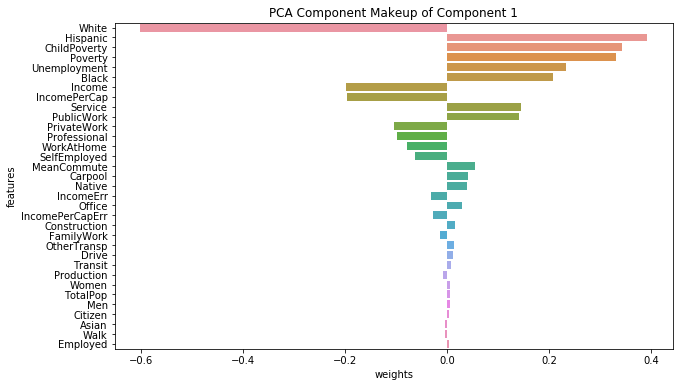

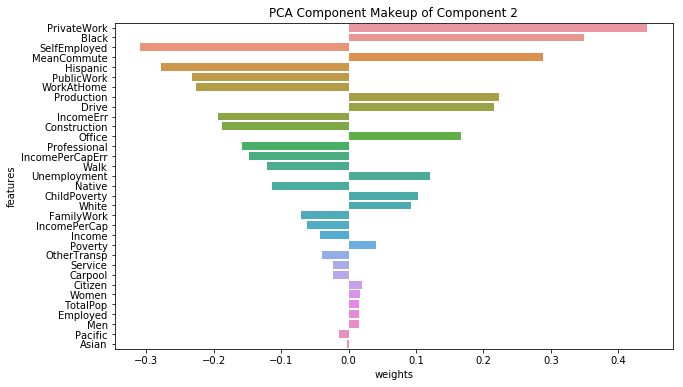

In [34]:
for idx in range(1, 3):
    display_component_makeup(v, feature_list=norm_census_df.columns.values,
                                component_idx=idx,
                                num_weights=33)

## Step 4 Deploy PCA with SageMaker

Now we can deploy the PCA model and use it as an endpoint without having to dig into the model params to transform an input.

In [35]:
%%time
pca_predictor = pca.deploy(initial_instance_count=1,
                           instance_type='ml.t2.medium')

-------------!CPU times: user 238 ms, sys: 15.3 ms, total: 254 ms
Wall time: 6min 33s


We don't need to use `RecordSet` anymore once the model is deployed. It will simply accept a `numpy` array to yield principal components.

In [59]:
pca_result = pca_predictor.predict(train_data_np)

SageMaker PCA returns a list of protobuf `Record` message, same length as the training data which is 3218 in this case. The protobuf `Record` message has the following format.

```protobuf
message Record {
    // Map from the name of the feature to the value.
    //
    // For vectors and libsvm-like datasets,
    // a single feature with the name `values`
    // should be specified.
    map<string, Value> features = 1;

    // An optional set of labels for this record.
    // Similar to the features field above, the key used for
    // generic scalar / vector labels should be 'values'.
    map<string, Value> label = 2;

    // A unique identifier for this record in the dataset.
    //
    // Whilst not necessary, this allows better
    // debugging where there are data issues.
    //
    // This is not used by the algorithm directly.
    optional string uid = 3;

    // Textual metadata describing the record.
    //
    // This may include JSON-serialized information
    // about the source of the record.
    //
    // This is not used by the algorithm directly.
    optional string metadata = 4;

    // An optional serialized JSON object that allows per-record
    // hyper-parameters/configuration/other information to be set.
    //
    // The meaning/interpretation of this field is defined by
    // the algorithm author and may not be supported.
    //
    // This is used to pass additional inference configuration
    // when batch inference is used (e.g. types of scores to return).
    optional string configuration = 5;
}
```

Essentially each data point is now projected onto a new component space. We can retrieve the projection by using the following syntax. 

In [63]:
pca_result[0].label['projection'].float32_tensor.values

[0.0002009272575378418, 0.0002455431967973709, -0.0005782842636108398, -0.0007815659046173096, -0.00041911262087523937, -0.0005133943632245064, -0.0011316537857055664, 0.0017268601804971695, -0.005361668765544891, -0.009066537022590637, -0.008141040802001953, -0.004735097289085388, -0.00716288760304451, 0.0003725700080394745, -0.01208949089050293, 0.02134685218334198, 0.0009293854236602783, 0.002417147159576416, -0.0034637749195098877, 0.01794189214706421, -0.01639425754547119, 0.06260128319263458, 0.06637358665466309, 0.002479255199432373, 0.10011336207389832, -0.1136140376329422, 0.02589476853609085, 0.04045158624649048, -0.01082391943782568, 0.1204797774553299, -0.0883558839559555, 0.16052711009979248, -0.06027412414550781]

Now we can transform the PCA result into a DataFrame that we can work with.

In [67]:
def create_pca_transformed_df(original_data, pca_transformed_data, num_top_components):
    """
    Return a DataFrame of data points with component features. The DF should be indexed by State-County and
    contain component values.
    """
    df = pd.DataFrame()
    for record in pca_transformed_data:
        projection_values = record.label['projection'].float32_tensor.values
        df = df.append([projection_values])
        
    df.index = original_data.index
    df = df.iloc[:, NUM_COMPONENTS-num_top_components:]
    return df.iloc[:, ::-1] # Reverse the ordering, such that most important component is shown first.

In [68]:
# Manually pick top 7 components.
pca_transformed_census_df = create_pca_transformed_df(norm_census_df, pca_result, 7) 
pca_transformed_census_df.columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
pca_transformed_census_df.head()

,c1,c2,c3,c4,c5,c6,c7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


## Step 5 Train KMeans with SageMaker

We will arbitrarily pick 8 clusters for KMeans. To train the model, we need to pass in `RecordSet` again.

In [70]:
from sagemaker import KMeans

NUM_CLUSTERS = 8

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=model_output_path,
                k=NUM_CLUSTERS)

train_data_np = pca_transformed_census_df.values.astype('float32')
train_data_record_set = kmeans.record_set(train_data_np)

job_name = strftime("population-segmentation-kmeans-%Y-%m-%d-%H-%M-%S", localtime())
kmeans.fit(train_data_record_set, job_name=job_name)

2020-04-06 23:43:44 Starting - Starting the training job...
2020-04-06 23:43:45 Starting - Launching requested ML instances......
2020-04-06 23:44:45 Starting - Preparing the instances for training......
2020-04-06 23:46:05 Downloading - Downloading input data...
2020-04-06 23:46:40 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/06/2020 23:46:44 INFO 140411556333376] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_cen


2020-04-06 23:46:52 Uploading - Uploading generated training model
2020-04-06 23:46:52 Completed - Training job completed
Training seconds: 47
Billable seconds: 47


In [72]:
%%time
# Also deploy it
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

-----------------------------!CPU times: user 459 ms, sys: 20.4 ms, total: 479 ms
Wall time: 14min 36s


## Step 6 Clustering 

Now we can perform clustering and explore the result of clustering.

In [73]:
cluster_info = kmeans_predictor.predict(train_data_np)

### 6.1 Explore the Resultant Clusters

Let's see which cluster is each data point assigned to. We can simply randomly select few data points by indices and check their cluster information using the same indices.

In [75]:
import random
for i in range(3):
    data_index = random.randint(0,len(train_data_np))
    print('County: {}\n'.format(pca_transformed_census_df.index[data_index]))
    print(cluster_info[data_index])

County: Colorado-Garfield

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.3327351212501526
    }
  }
}

County: Texas-Shelby

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.3395182192325592
    }
  }
}

County: Louisiana-Evangeline

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.3210434317588806
    }
  }
}



Let's take a look at the data point distribution across clusters.

6.0    999
0.0    606
1.0    425
2.0    379
5.0    369
4.0    291
3.0     98
7.0     51
Name: 0, dtype: int64

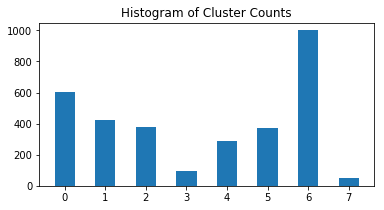

In [77]:
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()
display(cluster_df)

ax = plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8, range=(-0.5, 7.5), rwidth=0.5)
plt.title('Histogram of Cluster Counts', fontsize=12)
plt.show()

### 6.2 Load Model Artifacts (instead of using Predict)

We want to dig a little deeper to understand where are the centroids and what do they look like in the 7-dimensional space.

In [78]:
model_key = os.path.join(prefix, job_name, 'output/model.tar.gz')
print('Loading artifacts from {}'.format(model_key))

boto3.resource('s3').Bucket(session_bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Loading artifacts from population-segmentation/population-segmentation-kmeans-2020-04-06-23-43-44/output/model.tar.gz


2304

In [79]:
kmeans_model_params = mx.ndarray.load('model_algo-1')
pprint.pprint(kmeans_model_params)

[
[[-0.02251747  0.08905876  0.17157373 -0.04806723  0.00632851  0.11663745
  -0.02355854]
 [-0.17932147  0.07183108 -0.3180788   0.070527   -0.0244734   0.05766358
   0.0124713 ]
 [ 0.3787895   0.24803953  0.07842267  0.27025062  0.07873817 -0.0716323
   0.05168937]
 [ 1.2215096  -0.23992902 -0.19631913 -0.40215966 -0.08697513  0.09118532
   0.11438478]
 [ 0.20756531 -0.14692396 -0.09451014 -0.10918342  0.09122091 -0.09337081
  -0.07659711]
 [-0.2621782  -0.37752372  0.08524974  0.08468443  0.05860636 -0.00327792
   0.08481469]
 [-0.17384098  0.06186541  0.02547553 -0.06141954 -0.0519999  -0.03896767
  -0.01417946]
 [ 0.6351353  -0.5854497   0.10829799  0.28468394 -0.25043395  0.02687342
  -0.22321643]]
<NDArray 8x7 @cpu(0)>]


There is only 1 set of model parameters contained within the K-means model; the cluster centroid locations in PCA-transformed, component space.

In [80]:
centroid_df = pd.DataFrame(kmeans_model_params[0].asnumpy())
centroid_df.columns = pca_transformed_census_df.columns
display(centroid_df)

,c1,c2,c3,c4,c5,c6,c7
0,-0.022517,0.089059,0.171574,-0.048067,0.006329,0.116637,-0.023559
1,-0.179321,0.071831,-0.318079,0.070527,-0.024473,0.057664,0.012471
2,0.378790,0.248040,0.078423,0.270251,0.078738,-0.071632,0.051689
3,1.221510,-0.239929,-0.196319,-0.402160,-0.086975,0.091185,0.114385
4,0.207565,-0.146924,-0.094510,-0.109183,0.091221,-0.093371,-0.076597
5,-0.262178,-0.377524,0.085250,0.084684,0.058606,-0.003278,0.084815
6,-0.173841,0.061865,0.025476,-0.061420,-0.052000,-0.038968,-0.014179
7,0.635135,-0.585450,0.108298,0.284684,-0.250434,0.026873,-0.223216


### 6.3 Visualize Centroids in Component Space

We can't visualize a 7-dimensional centroid in Cartesian space, but we can plot a heatmap of the centroids and their location in transformed feature space.

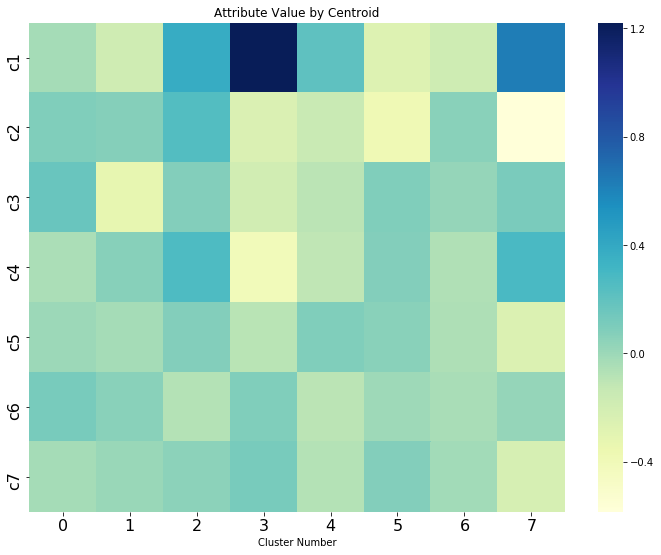

In [81]:
plt.figure(figsize=(12,9))
ax = seaborn.heatmap(centroid_df.T, cmap='YlGnBu')
ax.set_xlabel('Cluster Number')
ax.set_title('Attribute Value by Centroid')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

### 6.4 Examine the Grouping

Finally we should map the labels back to the census transformed `DataFrame` to understand the grouping of different counties. 

In [85]:
pca_transformed_census_df['labels'] = list(map(int, cluster_labels))
pca_transformed_census_df.sort_values('labels', ascending=True).head(20)

,c1,c2,c3,c4,c5,c6,c7,labels
Tennessee-Wayne,0.063113,0.104933,0.285298,-0.041470,-0.083603,0.179846,-0.040195,0
Georgia-Morgan,-0.024062,0.063064,-0.021719,0.181931,0.091352,0.053852,0.089129,0
Georgia-Murray,0.002309,0.277421,0.149035,-0.284987,0.033298,-0.058308,-0.006328,0
Kentucky-Garrard,-0.077484,0.158746,0.149348,-0.117317,0.036888,0.273137,0.018827,0
North Carolina-Stanly,0.004421,0.140494,0.077001,-0.009013,-0.050588,0.053955,-0.044574,0
Kentucky-Floyd,0.050515,0.081900,0.294386,-0.073164,-0.201384,0.176484,0.052943,0
Georgia-Oglethorpe,-0.023825,0.027835,0.080744,0.103825,0.138597,0.102568,0.076467,0
Kentucky-Fleming,-0.142175,0.087977,0.215186,-0.122501,0.099160,0.152931,0.051317,0
Virginia-Wise,-0.036725,0.082495,0.166730,-0.020731,-0.054882,0.072931,-0.018200,0
Kentucky-Grant,-0.124348,0.271452,0.145990,-0.192828,0.035439,0.095130,-0.112029,0


## Step 7 Cleanup

Delete all the endpoints.

In [86]:
session.delete_endpoint(pca_predictor.endpoint)
session.delete_endpoint(kmeans_predictor.endpoint)